# 🧠 EEG Eye State Detection using Machine Learning
### A Brain-Computer Interface (BCI) Project


## Project Overview
This project aims to classify the state of the eye (Open vs. Closed) based on continuous Electroencephalogram (EEG) signals. The data was collected from an Emotiv EPOC+ headset with 14 distinct sensors.

**Objective:** Build a robust Machine Learning model to accurately predict `eyeDetection` (0 or 1) based on brainwave activity.
**Applications:** Drowsiness detection, BCI control systems, and neurological monitoring.

## Dataset Description
The dataset consists of **14,980** samples and **15** attributes:
* **Features:** 14 continuous EEG measurements (AF3, F7, F3, FC5, T7, P7, O1, O2, P8, T8, FC6, F4, F8, AF4).
* **Target:** `eyeDetection` (1 = Eye Open, 0 = Eye Closed).

In [ ]:
import warnings
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from scipy import stats
from scipy.stats import skew, kurtosis, entropy, wilcoxon
from scipy.signal import welch, butter, filtfilt

from sklearn.preprocessing import StandardScaler, RobustScaler
from sklearn.decomposition import PCA
from sklearn.model_selection import (
    train_test_split, StratifiedKFold, GridSearchCV, 
    cross_val_score
)
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import classification_report, confusion_matrix

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import (
    Conv1D, MaxPooling1D, BatchNormalization, Activation,
    LSTM, Bidirectional, Dropout, TimeDistributed, Dense
)
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau

# Configuration
warnings.filterwarnings('ignore')

Dataset Shape: (14980, 15)

Data Types:
 AF3             float64
F7              float64
F3              float64
FC5             float64
T7              float64
P7              float64
O1              float64
O2              float64
P8              float64
T8              float64
FC6             float64
F4              float64
F8              float64
AF4             float64
eyeDetection      int64
dtype: object

Null Values:
 AF3             0
F7              0
F3              0
FC5             0
T7              0
P7              0
O1              0
O2              0
P8              0
T8              0
FC6             0
F4              0
F8              0
AF4             0
eyeDetection    0
dtype: int64

Descriptive Statistics:
                  AF3            F7            F3            FC5            T7  \
count   14980.000000  14980.000000  14980.000000   14980.000000  14980.000000   
mean     4321.917777   4009.767694   4264.022433    4164.946326   4341.741075   
std      2492.0721

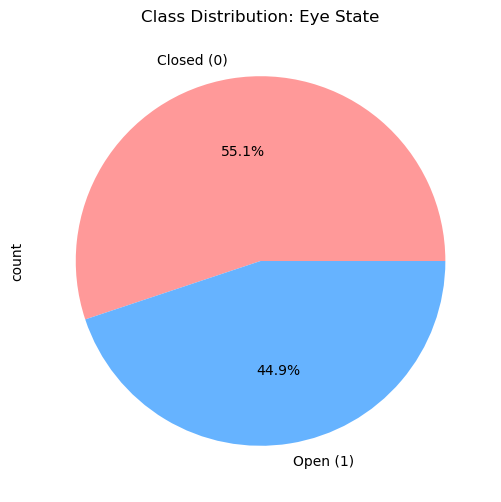

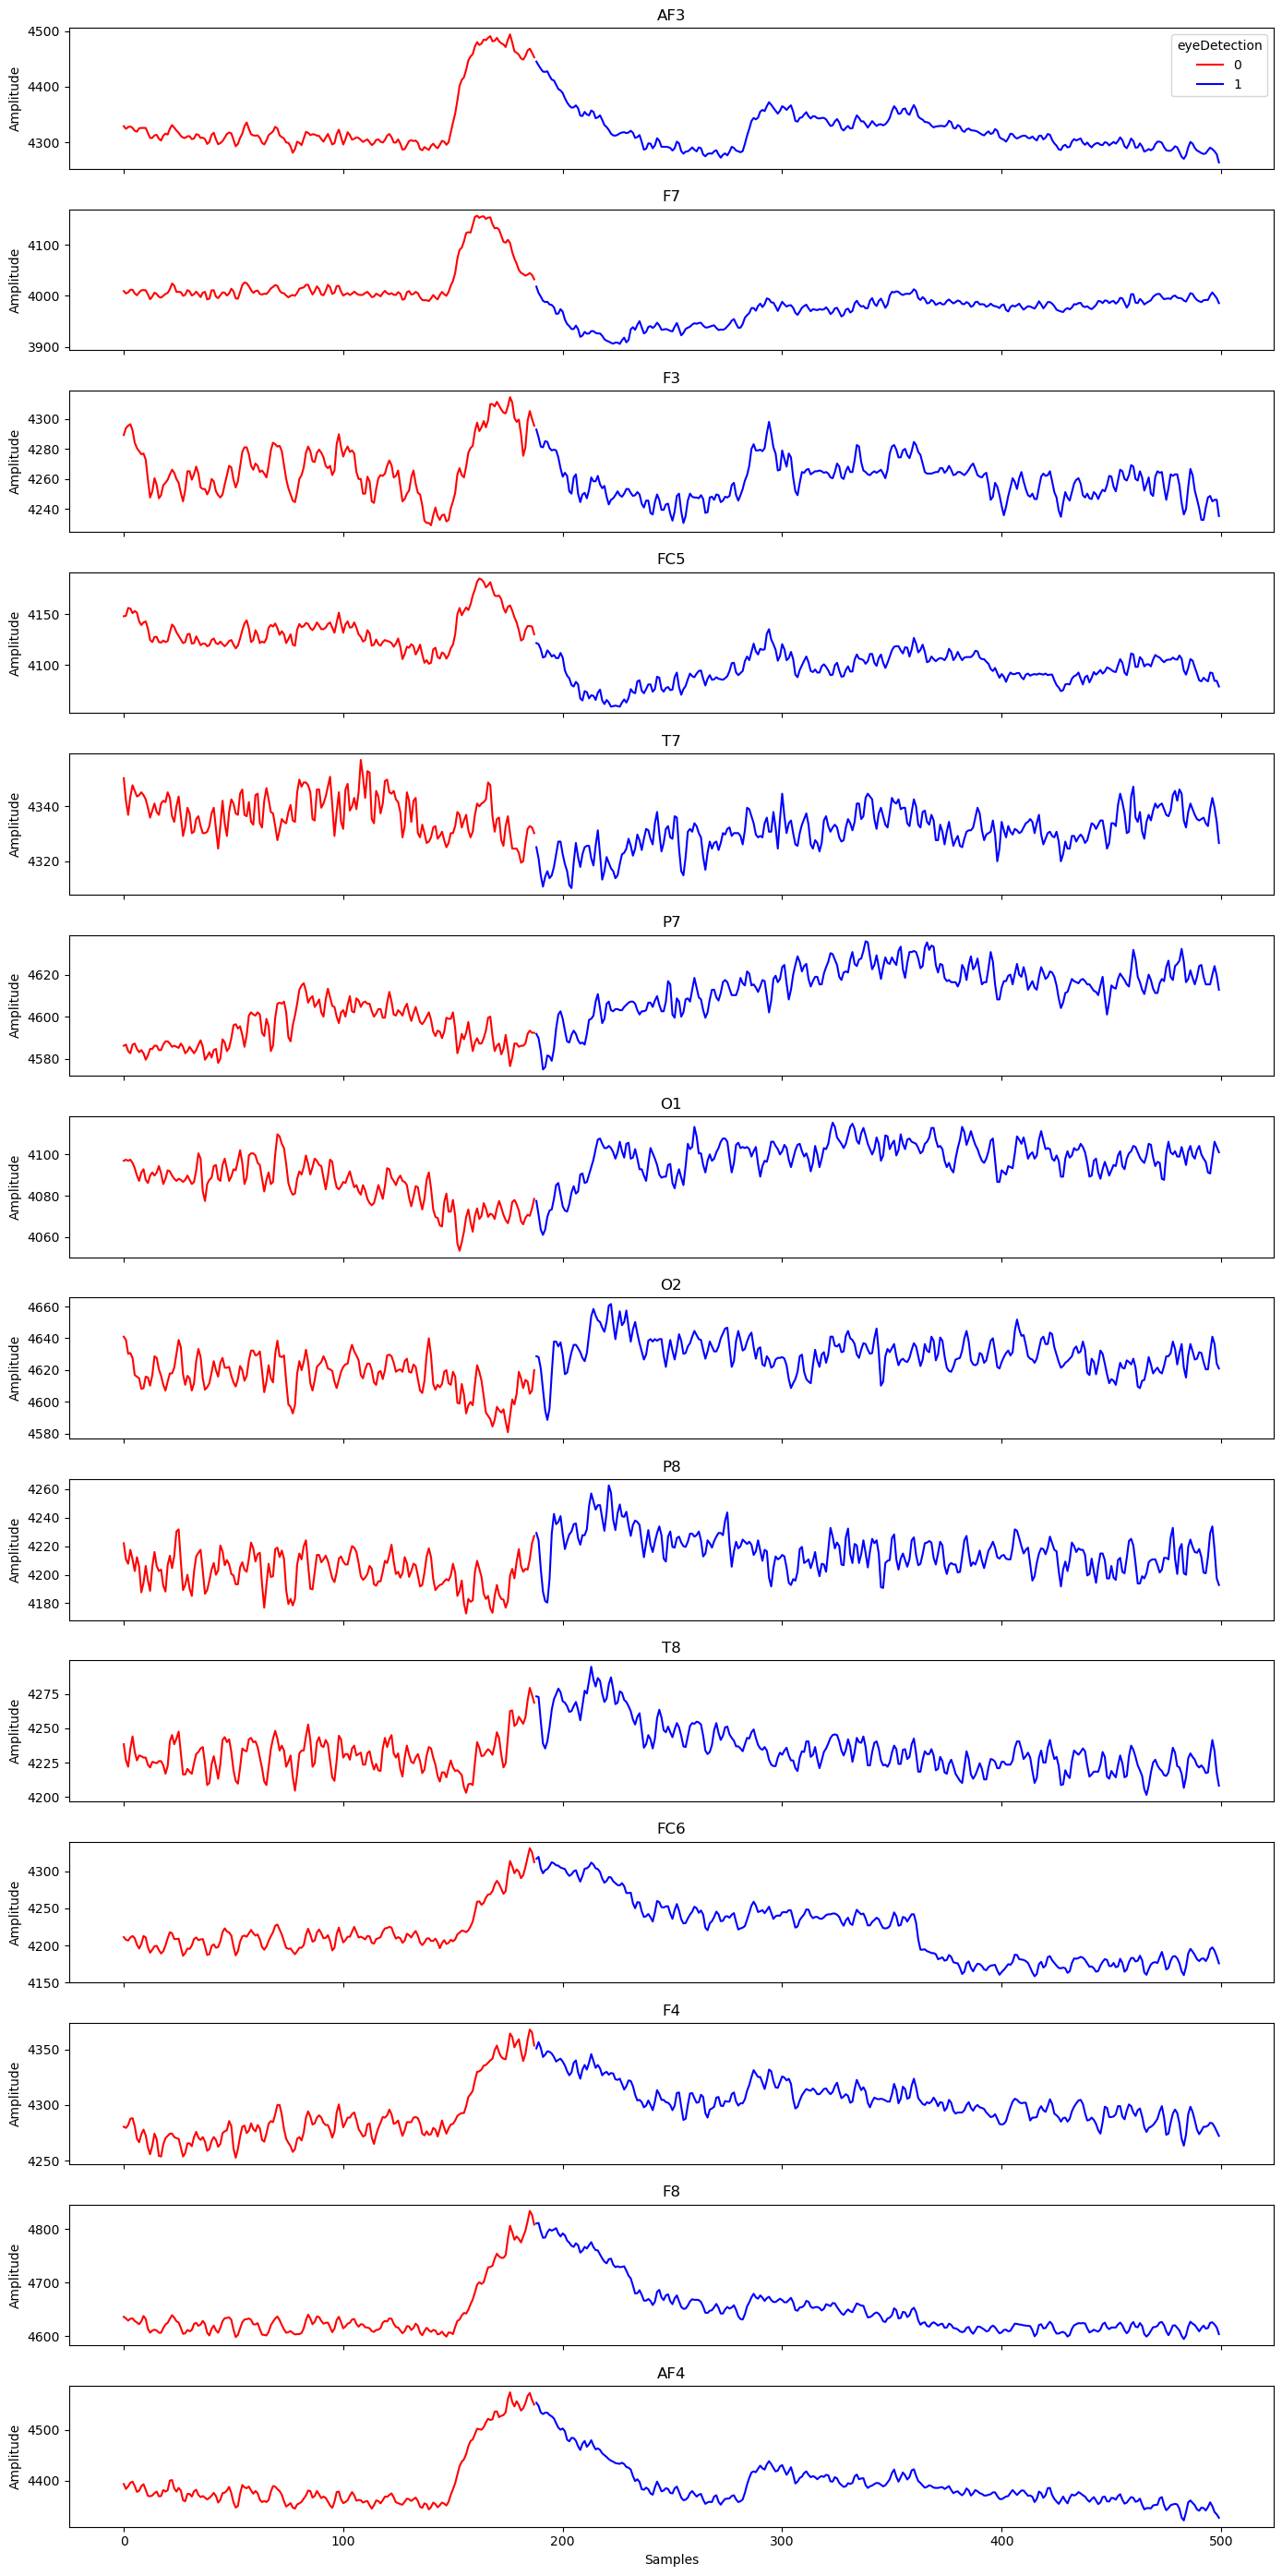

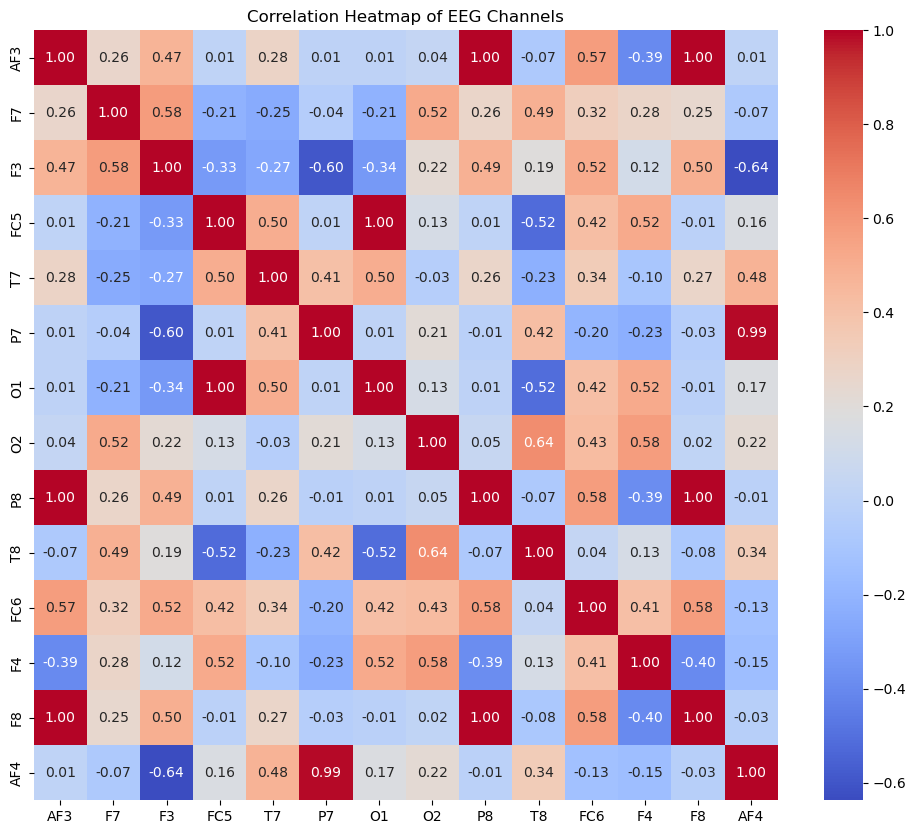

In [12]:
#1.1
df = pd.read_csv('EEG_Eye_State_Classification.csv')

print("Dataset Shape:", df.shape)
print("\nData Types:\n", df.dtypes)
print("\nNull Values:\n", df.isnull().sum())

print("\nDescriptive Statistics:\n", df.describe())

plt.figure(figsize=(6, 6))
df['eyeDetection'].value_counts().plot.pie(autopct='%1.1f%%', labels=['Closed (0)', 'Open (1)'], colors=['#ff9999','#66b3ff'])
plt.title('Class Distribution: Eye State')
plt.show()

eeg_channels = [
    'AF3','F7','F3','FC5','T7','P7','O1',
    'O2','P8','T8','FC6','F4','F8','AF4'
]
N = 500

fig, axes = plt.subplots(len(eeg_channels), 1, figsize=(14, 2*len(eeg_channels)), sharex=True)

for i, ch in enumerate(eeg_channels):
    sns.lineplot(
        data=df.iloc[:N],
        x=df.index[:N],
        y=ch,
        hue='eyeDetection',
        palette=['red', 'blue'],
        ax=axes[i],
        legend=(i == 0)  # show legend only once
    )
    axes[i].set_title(ch)
    axes[i].set_ylabel('Amplitude')

plt.xlabel('Samples')
plt.tight_layout()
plt.show()


plt.figure(figsize=(12, 10))
# Exclude target variable for channel correlation
sns.heatmap(df.drop(columns=['eyeDetection']).corr(), annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Correlation Heatmap of EEG Channels')
plt.show()


Outliers detected per channel (Threshold Z > 3):
AF3     1
F7     17
F3      4
FC5     1
T7     37
P7      1
O1      1
O2     66
P8      1
T8     25
FC6    46
F4      4
F8      3
AF4     2
dtype: int64


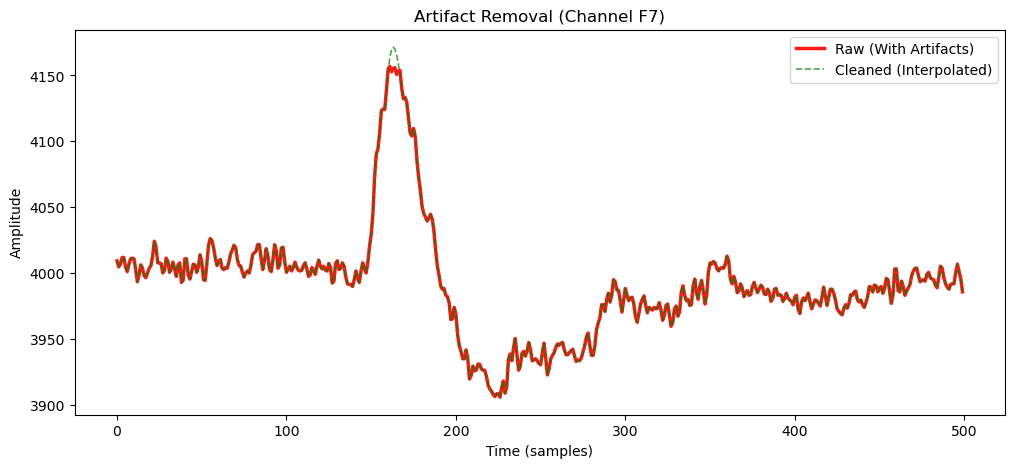

In [13]:
#1.2
z_scores = np.abs(stats.zscore(df[eeg_channels]))
threshold = 3 #common threshold (the normaal dist graph)
outliers = (z_scores > threshold)

print(f"\nOutliers detected per channel (Threshold Z > {threshold}):")
print(outliers.sum(axis=0))

df_clean = df.copy()
df_clean[eeg_channels] = df_clean[eeg_channels].mask(outliers)

df_clean[eeg_channels] = df_clean[eeg_channels].interpolate(method='cubic', limit_direction='both')

plt.figure(figsize=(12, 5))

x = range(500)

plt.plot(
    x,
    df['F7'].iloc[:500],
    label='Raw (With Artifacts)',
    color='red',
    linewidth=2.5,
    alpha=0.9,
    zorder=1
)

plt.plot(
    x,
    df_clean['F7'].iloc[:500],
    label='Cleaned (Interpolated)',
    color='green',
    linestyle='--',
    linewidth=1.2,     # thinner
    alpha=0.7,         # more transparent
    zorder=2
)

plt.title('Artifact Removal (Channel F7)')
plt.xlabel('Time (samples)')
plt.ylabel('Amplitude')
plt.legend()
plt.show()


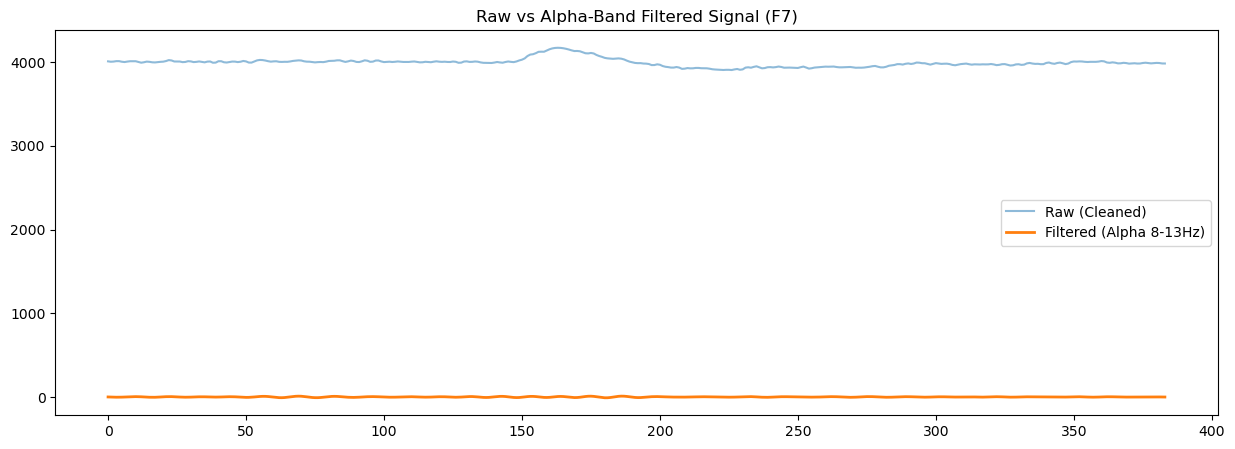

In [14]:
#1.3
def butter_bandpass_filter(data, lowcut, highcut, fs, order=4):
    nyq = 0.5 * fs
    low = lowcut / nyq
    high = highcut / nyq
    b, a = butter(order, [low, high], btype='band')
    y = filtfilt(b, a, data)
    return y

fs = 128
df_filtered = df_clean.copy()
for col in eeg_channels:
    df_filtered[col] = butter_bandpass_filter(df_clean[col], 8, 13, fs)


plt.figure(figsize=(15, 5))
plt.plot(df_clean['F7'].iloc[:384], label='Raw (Cleaned)', alpha=0.5)
plt.plot(df_filtered['F7'].iloc[:384], label='Filtered (Alpha 8-13Hz)', linewidth=2)
plt.title('Raw vs Alpha-Band Filtered Signal (F7)')
plt.legend()
plt.show()


In [15]:
#1.4
scaler = StandardScaler()
df_normalized = pd.DataFrame(scaler.fit_transform(df_filtered[eeg_channels]), columns=eeg_channels)
df_normalized['eyeDetection'] = df['eyeDetection'] # add target back

------------------------------------

In [16]:
#clean without filtering
df_normalized_clean = pd.DataFrame(scaler.fit_transform(df_clean[eeg_channels]), columns=eeg_channels)
df_normalized_clean['eyeDetection'] = df['eyeDetection'] 


In [17]:
#2.1

def extract_temporal_features(data):
    features = {}

    features['mean'] = np.mean(data)
    features['std'] = np.std(data)
    features['var'] = np.var(data)
    features['rms'] = np.sqrt(np.mean(data**2))
    features['skewness'] = skew(data)
    features['kurtosis'] = kurtosis(data)
    features['peak'] = np.max(np.abs(data))
    features['crest_factor'] = features['peak'] / features['rms']
    features['zcr'] = ((data[:-1] * data[1:]) < 0).sum() / len(data)
    pd_series = pd.Series(data)
    counts = pd_series.value_counts()
    features['entropy'] = entropy(counts)

    return features



# apply this function over each feature we have no window, just the direct columns
temporal_features = df_normalized[eeg_channels].apply(extract_temporal_features)
temporal_features_df = pd.DataFrame(temporal_features.tolist(), index=eeg_channels)
print("\nExtracted Temporal Features:\n", temporal_features_df.head())


Extracted Temporal Features:
              mean  std  var  rms  skewness    kurtosis       peak  \
AF3 -2.601390e-18  1.0  1.0  1.0  0.002102  202.499373  21.560701   
F7  -1.944743e-17  1.0  1.0  1.0  0.000557    0.577230   4.186771   
F3   2.104829e-17  1.0  1.0  1.0  0.000047    1.149316   5.423048   
FC5 -1.087989e-17  1.0  1.0  1.0 -0.002703  211.590430  25.106173   
T7  -1.285131e-17  1.0  1.0  1.0  0.000265    0.150958   4.988959   

     crest_factor  zcr   entropy  
AF3     21.560701  0.0  9.614471  
F7       4.186771  0.0  9.614471  
F3       5.423048  0.0  9.614471  
FC5     25.106173  0.0  9.614471  
T7       4.988959  0.0  9.614471  


Sample Spectral Features: {'Delta_abs': 42295407.09802632, 'Delta_rel': 0.37696373906422337, 'Theta_abs': 2464342.7423002888, 'Theta_rel': 0.021963799812123055, 'Alpha_abs': 1370066.2263295304, 'Alpha_rel': 0.012210907114472263, 'Beta_abs': 1569323.9251149525, 'Beta_rel': 0.01398681926014329, 'Gamma_abs': 587081.0438424593, 'Gamma_rel': 0.005232442021604466, 'centroid': 1.2852466145760784, 'spec_entropy': 7.4758445313616795}


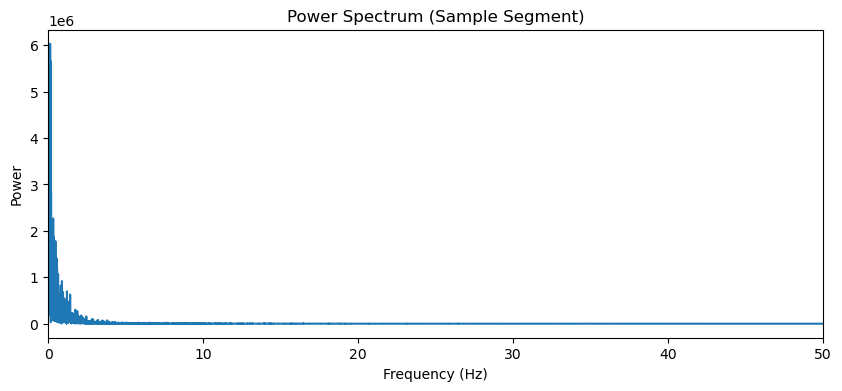

In [18]:
#2.2
def extract_spectral_features(data, fs=128):
    # FFT
    fft_vals = np.fft.rfft(data)
    fft_freq = np.fft.rfftfreq(len(data), 1.0/fs)
    power_spectrum = np.abs(fft_vals)**2

    # Define bands
    bands = {
        'Delta': (0.5, 4),
        'Theta': (4, 8),
        'Alpha': (8, 13),
        'Beta': (13, 30),
        'Gamma': (30, 50)
    }

    spectral_feats = {}
    total_power = np.sum(power_spectrum)

    for band, (low, high) in bands.items():
        # Find indices for the band
        idx = np.where((fft_freq >= low) & (fft_freq <= high))
        band_power = np.sum(power_spectrum[idx])
        spectral_feats[f'{band}_abs'] = band_power
        spectral_feats[f'{band}_rel'] = band_power / total_power

    # Spectral Centroid
    spectral_feats['centroid'] = np.sum(fft_freq * power_spectrum) / np.sum(power_spectrum)

    # Spectral Entropy
    ps_norm = power_spectrum / np.sum(power_spectrum)
    spectral_feats['spec_entropy'] = -np.sum(ps_norm * np.log2(ps_norm + 1e-12)) # epsilon for stability

    return fft_freq, power_spectrum, spectral_feats


freqs, powers, spec_feats = extract_spectral_features(df_normalized_clean['F7'].values)
print("Sample Spectral Features:", spec_feats)


plt.figure(figsize=(10, 4))
plt.plot(freqs, powers)
plt.title('Power Spectrum (Sample Segment)')
plt.xlabel('Frequency (Hz)')
plt.ylabel('Power')
plt.xlim(0, 50)
plt.show()


Alpha Power (Eyes Open):   603.64
Alpha Power (Eyes Closed): 1245.61


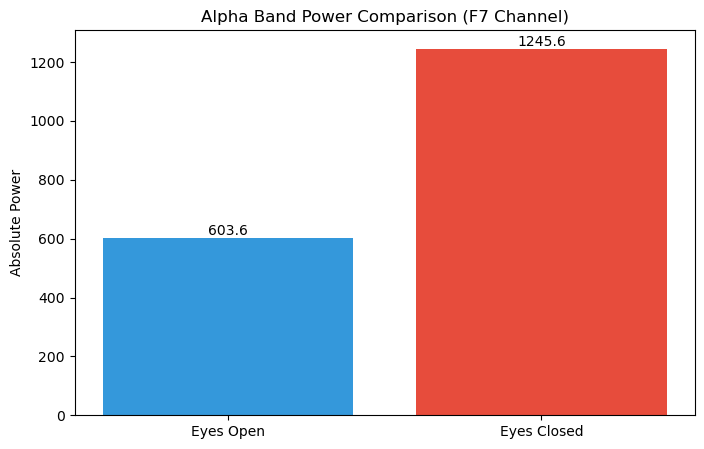

In [19]:
# 1. Define window size (e.g., 3 seconds * 128 Hz = 384 samples)
window_size = 3 * 128

segment_open = df_normalized_clean[df_normalized_clean['eyeDetection'] == 1]['F7'].values[:window_size]
segment_closed = df_normalized_clean[df_normalized_clean['eyeDetection'] == 0]['F7'].values[:window_size]

_, _, feats_open = extract_spectral_features(segment_open, fs=128)
_, _, feats_closed = extract_spectral_features(segment_closed, fs=128)

print(f"Alpha Power (Eyes Open):   {feats_open['Alpha_abs']:.2f}")
print(f"Alpha Power (Eyes Closed): {feats_closed['Alpha_abs']:.2f}")

labels = ['Eyes Open', 'Eyes Closed']
alpha_values = [feats_open['Alpha_abs'], feats_closed['Alpha_abs']]

plt.figure(figsize=(8, 5))
bars = plt.bar(labels, alpha_values, color=['#3498db', '#e74c3c'])
plt.title('Alpha Band Power Comparison (F7 Channel)')
plt.ylabel('Absolute Power')


for bar in bars:
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2., height,
             f'{height:.1f}',
             ha='center', va='bottom')

plt.show()

-------------------------

In [20]:
#3.1
X = df_normalized_clean[eeg_channels]
y = df_normalized_clean['eyeDetection']

corr_matrix = X.corr().abs()
upper = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(bool))
to_drop = [column for column in upper.columns if any(upper[column] > 0.8)]
print(f"\nNumber of features to remove: {len(to_drop)}")
print(f"Features to drop (high correlation): {to_drop}")
X_reduced = X.drop(columns=to_drop)
print("Shape after correlation selection:", X_reduced.shape)




Number of features to remove: 3
Features to drop (high correlation): ['FC6', 'F4', 'F8']
Shape after correlation selection: (14980, 11)


In [22]:
import pandas as pd
import numpy as np
from scipy.stats import skew, kurtosis, entropy

# ... include your definitions for extract_temporal_features and extract_spectral_features here ...

# 1. Define Windowing Parameters
sample_rate = 128        # 1 second window
step = 64                # 0.5 second overlap
feature_list = []
labels_list = []

print("Generating combined features... (This may take a moment)")

# 2. Iterate over the data with a sliding window
for i in range(0, len(df_normalized_clean) - sample_rate, step):
    window_data = df_normalized_clean.iloc[i:i+sample_rate]
    
    # Get the label for this window (majority vote)
    label = window_data['eyeDetection'].mode()[0]
    
    # Dictionary to hold all features for this specific window
    row_features = {}
    
    # 3. Extract features for EACH channel
    for channel in eeg_channels:
        # Get the raw signal for this channel in this window
        signal = window_data[channel].values
        
        # A. Get Temporal Features
        temp_feats = extract_temporal_features(signal)
        
        # B. Get Spectral Features
        _, _, spec_feats = extract_spectral_features(signal, fs=128)
        
        # C. Merge and Rename keys to include the channel name
        # Example: 'F7_mean', 'F7_Alpha_rel'
        
        for key, value in temp_feats.items():
            row_features[f"{channel}_{key}"] = value
            
        for key, value in spec_feats.items():
            row_features[f"{channel}_{key}"] = value
            
    feature_list.append(row_features)
    labels_list.append(label)

# 4. Create Final DataFrame
X_features = pd.DataFrame(feature_list)
y = np.array(labels_list)

print(f"Feature Extraction Complete.")
print(f"Total Features per Sample: {X_features.shape[1]}")
print(f"Total Samples: {X_features.shape[0]}")

Generating combined features... (This may take a moment)
Feature Extraction Complete.
Total Features per Sample: 308
Total Samples: 233


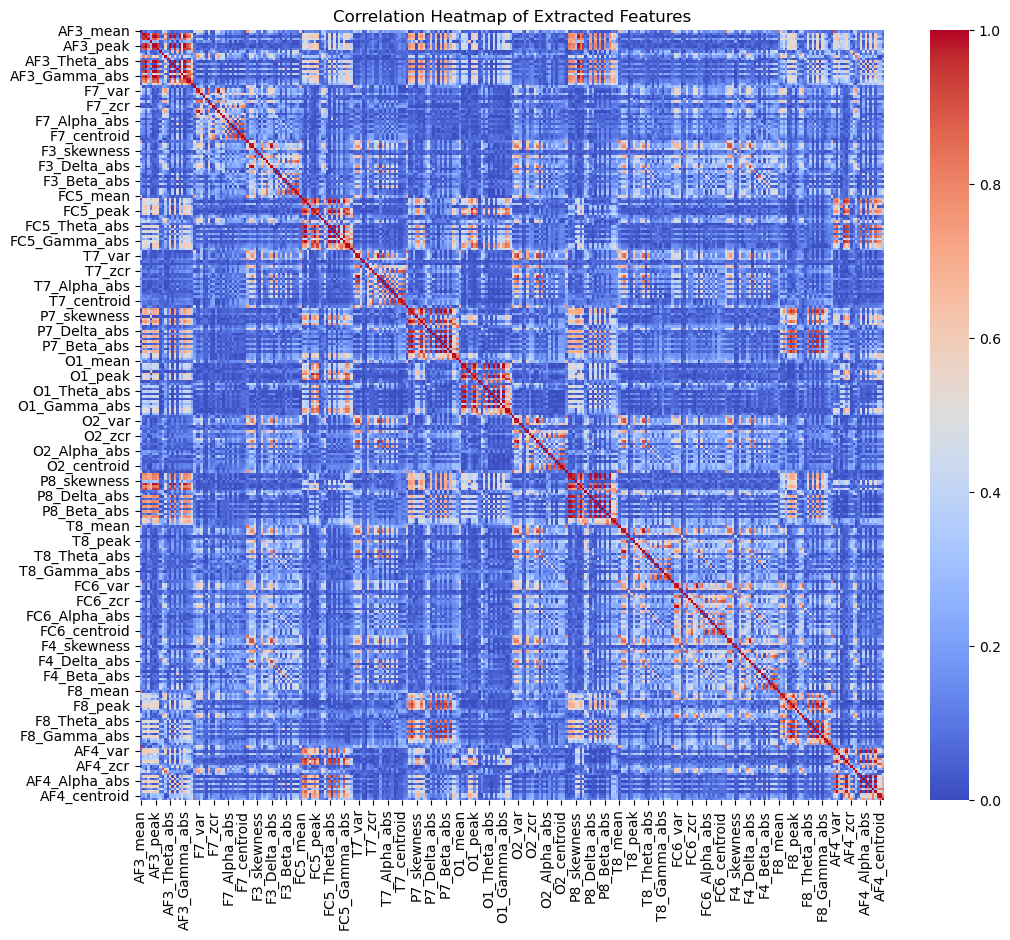


Number of features to remove: 169
Features to drop: ['AF3_var', 'AF3_rms', 'AF3_kurtosis', 'AF3_peak', 'AF3_crest_factor', 'AF3_Theta_abs', 'AF3_Alpha_abs', 'AF3_Beta_abs', 'AF3_Gamma_abs', 'AF3_Gamma_rel', 'AF3_centroid', 'AF3_spec_entropy', 'F7_var', 'F7_peak', 'F7_Delta_abs', 'F7_Beta_rel', 'F7_Gamma_rel', 'F7_centroid', 'F7_spec_entropy', 'F3_var', 'F3_peak', 'F3_Delta_abs', 'F3_Beta_rel', 'F3_Gamma_rel', 'F3_centroid', 'F3_spec_entropy', 'FC5_var', 'FC5_rms', 'FC5_kurtosis', 'FC5_peak', 'FC5_crest_factor', 'FC5_Delta_abs', 'FC5_Theta_abs', 'FC5_Alpha_abs', 'FC5_Beta_abs', 'FC5_Gamma_abs', 'FC5_Gamma_rel', 'FC5_centroid', 'FC5_spec_entropy', 'T7_var', 'T7_peak', 'T7_Delta_abs', 'T7_Theta_abs', 'T7_Alpha_abs', 'T7_Beta_rel', 'T7_Gamma_rel', 'T7_centroid', 'T7_spec_entropy', 'P7_mean', 'P7_var', 'P7_rms', 'P7_kurtosis', 'P7_peak', 'P7_crest_factor', 'P7_Delta_abs', 'P7_Theta_abs', 'P7_Alpha_abs', 'P7_Beta_abs', 'P7_Beta_rel', 'P7_Gamma_abs', 'P7_Gamma_rel', 'P7_centroid', 'P7_spec_e

In [23]:

corr_matrix = X_features.corr().abs()

# 2. Plot the Heatmap
plt.figure(figsize=(12, 10))
sns.heatmap(corr_matrix, cmap='coolwarm', vmin=0, vmax=1)
plt.title('Correlation Heatmap of Extracted Features')
plt.show()

# 3. Identify Highly Correlated Features (Your logic)
upper = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(bool))
to_drop = [column for column in upper.columns if any(upper[column] > 0.8)]

print(f"\nNumber of features to remove: {len(to_drop)}")
print(f"Features to drop: {to_drop}")

# 4. Drop them
X_final = X_features.drop(columns=to_drop)
print(f"Final Data Shape: {X_final.shape}")

Number of components needed to explain 95% variance: 63


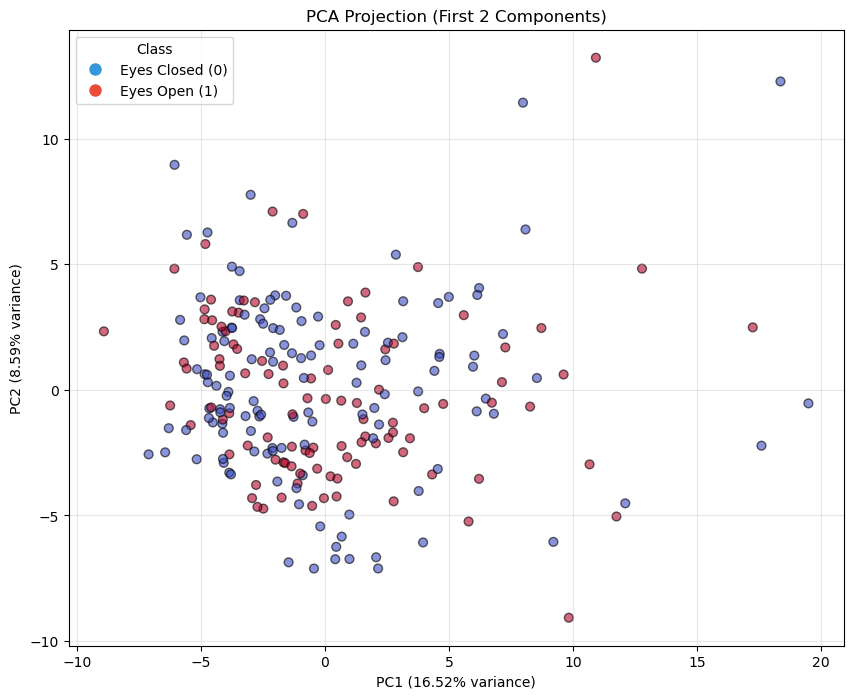

In [ ]:
#3.2

scaler_pca = StandardScaler()
X_scaled = scaler_pca.fit_transform(X_final)

pca = PCA()
pca.fit(X_scaled)


cumsum = np.cumsum(pca.explained_variance_ratio_)


# np.argmax returns the first index where the condition is True
n_95 = np.argmax(cumsum >= 0.95) + 1 

print(f"Number of components needed to explain 95% variance: {n_95}")

pca_2d = PCA(n_components=2)
X_pca_2d = pca_2d.fit_transform(X_scaled)

plt.figure(figsize=(10, 8))
scatter = plt.scatter(X_pca_2d[:, 0], X_pca_2d[:, 1], c=y, cmap='coolwarm', alpha=0.6, edgecolors='k', s=40)
plt.xlabel(f'PC1 ({pca.explained_variance_ratio_[0]:.2%} variance)')
plt.ylabel(f'PC2 ({pca.explained_variance_ratio_[1]:.2%} variance)')
plt.title('PCA Projection (First 2 Components)')
classes = ['Eyes Closed (0)', 'Eyes Open (1)']
colors = ['#3498db', '#e74c3c'] # Blue for 0, Red for 1
handles = [plt.Line2D([0], [0], marker='o', color='w', markerfacecolor=c, markersize=10) for c in colors]
plt.legend(handles, classes, title="Class")
plt.grid(True, alpha=0.3)
plt.show()

--------------------------------------------------

In [34]:
#4.1
df = pd.read_csv('EEG_Eye_State_Classification.csv')
eeg_channels = ['AF3','F7','F3','FC5','T7','P7','O1','O2','P8','T8','FC6','F4','F8','AF4']
fs = 128

# 1. Clean Outliers
df[eeg_channels] = df[eeg_channels].clip(lower=4000, upper=5000)

# 2. Broadband Filter
for col in eeg_channels:
    df[col] = butter_bandpass_filter(df[col], 0.5, 45, fs)

def create_windows(df, window_size_sec , fs):
    window_size_samples = int(window_size_sec * fs)
    step_size = 16 # it worked much better with 16 samples step size
    
    windows_data = []
    labels = []
    
    for start in range(0, len(df) - window_size_samples + 1, step_size):
        window = df.iloc[start : start + window_size_samples]
        windows_data.append(window[eeg_channels].values)
        labels.append(window['eyeDetection'].mode()[0])
        
    return np.array(windows_data), np.array(labels)


window_sizes = [0.5, 1.0, 2.0] #just samples
results_4_1 = {}
best_X = None
best_y = None

for size in window_sizes:
    X_temp, y_temp = create_windows(df, size, fs)
    
    unique, counts = np.unique(y_temp, return_counts=True)
    balance = dict(zip(unique, counts / len(y_temp)))
    
    results_4_1[size] = {'count': len(y_temp), 'balance': balance}
    print(f"Window: {size}s | Count: {len(y_temp)} | Balance: {balance}")
    
    if size == 1.0: #just choice
        best_X = X_temp
        best_y = y_temp

print(f"\nSelected Window Size: 1.5s (Shape: {best_X.shape})")


Window: 0.5s | Count: 933 | Balance: {0: 0.5530546623794212, 1: 0.44694533762057875}
Window: 1.0s | Count: 929 | Balance: {0: 0.5575888051668461, 1: 0.44241119483315394}
Window: 2.0s | Count: 921 | Balance: {0: 0.5591748099891423, 1: 0.44082519001085774}

Selected Window Size: 1.5s (Shape: (929, 128, 14))


In [35]:
#4.2
def extract_features(windows_data, fs):
    all_features = []
    
    for i in range(len(windows_data)):
        window = windows_data[i]
        win_features = []
        
        for ch in range(window.shape[1]):
            sig = window[:, ch]
            
            # Temporal (Log-Variance)
            var = np.var(sig)
            win_features.append(np.log1p(var)) 
            
            # Hjorth
            diff1 = np.diff(sig)
            diff2 = np.diff(diff1)
            mobility = np.sqrt(np.var(diff1) / (var + 1e-12))
            complexity = (np.sqrt(np.var(diff2) / (np.var(diff1) + 1e-12))) / (mobility + 1e-12)
            win_features.append(mobility)
            win_features.append(complexity)

            # Spectral (Log-Power)
            freqs, psd = welch(sig, fs=fs, nperseg=min(64, len(sig)))
            bands = {'delta': (0.5, 4), 'theta': (4, 8), 'alpha': (8, 13), 'beta': (13, 30)}
            
            for band, (low, high) in bands.items():
                idx = np.logical_and(freqs >= low, freqs <= high)
                power = np.trapz(psd[idx], freqs[idx]) if any(idx) else 0
                win_features.append(np.log1p(power))

        all_features.append(win_features)
    return np.array(all_features)

X_features = extract_features(best_X, fs)
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X_features)
y_labels = best_y
print(f"Features Extracted & Normalized. Shape: {X_scaled.shape}")

Features Extracted & Normalized. Shape: (929, 98)


In [36]:
#4.3

cv = StratifiedKFold(n_splits=10, shuffle=True, random_state=42)

model_configs = {
    'SVM': {
        'model': SVC(kernel='rbf'),
        'params': {'C': [1, 10], 'gamma': ['scale', 0.1]} 
    },
    'RF': {
        'model': RandomForestClassifier(random_state=42),
        'params': {'n_estimators': [100, 200], 'max_depth': [None, 20]}
    },
    'KNN': {
        'model': KNeighborsClassifier(),
        'params': {'n_neighbors': [3, 5, 7]}
    }
}

results = {}

for name, config in model_configs.items():
    print(f"Running GridSearch for {name}...")
    grid = GridSearchCV(config['model'], config['params'], cv=3, scoring='accuracy', n_jobs=-1)
    grid.fit(X_scaled, y_labels)
    best_model = grid.best_estimator_
    scores = cross_val_score(best_model, X_scaled, y_labels, cv=cv, scoring='accuracy')
    
    results[name] = {'scores': scores, 'mean': scores.mean(), 'std': scores.std(), 
                     'best_params': grid.best_params_, 'model': best_model}
    
    print(f"  Mean Accuracy: {scores.mean():.4f} (+/- {scores.std():.4f})")

# Identify Best Model
best_model_name = max(results, key=lambda k: results[k]['mean'])
best_overall_model = results[best_model_name]['model']

# Final Report
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y_labels, test_size=0.2, stratify=y_labels)
best_overall_model.fit(X_train, y_train)
y_pred = best_overall_model.predict(X_test)

print(f"\nTop Performing Model: {best_model_name}")
print("\n--- Final Classification Report ---")
print(classification_report(y_test, y_pred))
print("Confusion Matrix:")
print(confusion_matrix(y_test, y_pred))

Running GridSearch for SVM...
  Mean Accuracy: 0.9656 (+/- 0.0224)
Running GridSearch for RF...
  Mean Accuracy: 0.9354 (+/- 0.0180)
Running GridSearch for KNN...
  Mean Accuracy: 0.9634 (+/- 0.0227)

Top Performing Model: SVM

--- Final Classification Report ---
              precision    recall  f1-score   support

           0       0.95      0.97      0.96       104
           1       0.96      0.94      0.95        82

    accuracy                           0.96       186
   macro avg       0.96      0.96      0.96       186
weighted avg       0.96      0.96      0.96       186

Confusion Matrix:
[[101   3]
 [  5  77]]


SVM vs RF: Statistic=1.000, p-value=0.0170 (Significant)
SVM vs KNN: Statistic=15.500, p-value=0.7243 (Not Significant)
RF vs KNN: Statistic=0.000, p-value=0.0116 (Significant)


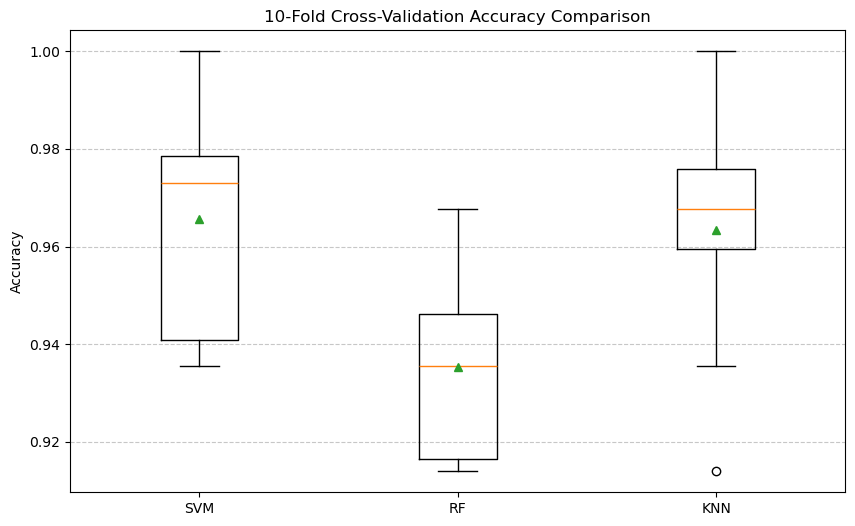

In [37]:
#4.4
comparisons = [('SVM', 'RF'), ('SVM', 'KNN'), ('RF', 'KNN')]

for m1, m2 in comparisons:
    # Use the 10-fold scores stored in results
    stat, p_val = wilcoxon(results[m1]['scores'], results[m2]['scores'])
    significance = "Significant" if p_val < 0.05 else "Not Significant"
    print(f"{m1} vs {m2}: Statistic={stat:.3f}, p-value={p_val:.4f} ({significance})")

plt.figure(figsize=(10, 6))
data_to_plot = [results['SVM']['scores'], results['RF']['scores'], results['KNN']['scores']]
plt.boxplot(data_to_plot, labels=['SVM', 'RF', 'KNN'], showmeans=True)
plt.title('10-Fold Cross-Validation Accuracy Comparison')
plt.ylabel('Accuracy')
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

-----------

In [63]:
#5.1
def create_sequences(data, labels, seq_length=128, step_size=32):
    X_seq, y_seq = [], []
    for i in range(0, len(data) - seq_length, step_size):
        X_seq.append(data[i:i + seq_length])
        # For sequence labeling, keep the sequence of labels
        y_seq.append(labels[i:i + seq_length])
    return np.array(X_seq), np.array(y_seq)

X_scaled = df_normalized_clean[eeg_channels].values
y = df_normalized_clean['eyeDetection'].values

# Create more data: Using a step_size of 32 instead of 128 (75% overlap)
X_seq, y_seq = create_sequences(X_scaled, y, seq_length=128, step_size=32)

# Reshape y for TimeDistributed output if needed (samples, seq_len, 1)
y_seq = y_seq.reshape(y_seq.shape[0], y_seq.shape[1], 1)

X_train, X_test, y_train, y_test = train_test_split(X_seq, y_seq, test_size=0.2, random_state=42)

print(f"Sequence Shape: {X_seq.shape}") # (num_sequences, seq_length, num_channels)
print(f"Labels Shape: {y_seq.shape}")   # (num_sequences, seq_length)

Sequence Shape: (465, 128, 14)
Labels Shape: (465, 128, 1)


In [64]:
#5.2
SEQ_LENGTH = 128
# The actual number of features per timestep is 140, not 14, as X_train contains
# the extracted features (10 features for each of the 14 PCA components).
# We should get the number of features directly from X_train's shape.
num_features_per_timestep = X_train.shape[2]

model_lstm = Sequential([
    Bidirectional(LSTM(64, return_sequences=True), input_shape=(SEQ_LENGTH, num_features_per_timestep)),
    Dropout(0.3),
    Bidirectional(LSTM(32, return_sequences=True)),
    Dropout(0.3),
    TimeDistributed(Dense(1, activation='sigmoid'))
])

model_lstm.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

early_stop = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

history = model_lstm.fit(X_train, y_train, validation_split=0.2,
                         epochs=50, batch_size=32, callbacks=[early_stop])

# Extract the final accuracy
acc_lstm = history.history['val_accuracy'][-1]

Epoch 1/50
10/10 ━━━━━━━━━━━━━━━━━━━━ 10s 255ms/step - accuracy: 0.5764 - loss: 0.6701 - val_accuracy: 0.5971 - val_loss: 0.6567
Epoch 2/50
10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 89ms/step - accuracy: 0.6581 - loss: 0.6119 - val_accuracy: 0.6190 - val_loss: 0.6381
Epoch 3/50
10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 89ms/step - accuracy: 0.7056 - loss: 0.5660 - val_accuracy: 0.6388 - val_loss: 0.5936
Epoch 4/50
10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 89ms/step - accuracy: 0.7365 - loss: 0.5138 - val_accuracy: 0.7518 - val_loss: 0.5286
Epoch 5/50
10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 91ms/step - accuracy: 0.8231 - loss: 0.4262 - val_accuracy: 0.8208 - val_loss: 0.4199
Epoch 6/50
10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 100ms/step - accuracy: 0.8836 - loss: 0.3095 - val_accuracy: 0.8774 - val_loss: 0.3200
Epoch 7/50
10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 91ms/step - accuracy: 0.9329 - loss: 0.2039 - val_accuracy: 0.9186 - val_loss: 0.2132
Epoch 8/50
10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 100ms/step - accuracy: 0.9508 - loss: 0.1419 - val_accuracy: 0.9286

In [ ]:
#5.3

SEQ_LENGTH = 128
num_features_per_timestep = X_train.shape[2]

model_hybrid_v2 = Sequential([
    Conv1D(filters=128, kernel_size=7, padding='same', input_shape=(SEQ_LENGTH, num_features_per_timestep)),
    BatchNormalization(),    
    Activation('relu'),  

    Bidirectional(LSTM(128, return_sequences=True)), 
    BatchNormalization(),
    Dropout(0.4),          

    Bidirectional(LSTM(64, return_sequences=True)),
    BatchNormalization(),
    Dropout(0.3),

    TimeDistributed(Dense(1, activation='sigmoid'))
])


optimizer = Adam(learning_rate=0.001)
model_hybrid_v2.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=['accuracy'])
early_stop = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

# Reduce LR: If val_loss doesn't improve for 3 epochs, cut learning rate by half
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3, min_lr=0.00001, verbose=1)

history_hybrid_v2 = model_hybrid_v2.fit(
    X_train, y_train, 
    validation_split=0.2,
    epochs=100,            
    batch_size=32, 
    callbacks=[early_stop, reduce_lr]
)

Epoch 1/100
10/10 ━━━━━━━━━━━━━━━━━━━━ 13s 367ms/step - accuracy: 0.6501 - loss: 0.7563 - val_accuracy: 0.7153 - val_loss: 0.6633 - learning_rate: 0.0010
Epoch 2/100
10/10 ━━━━━━━━━━━━━━━━━━━━ 2s 184ms/step - accuracy: 0.7818 - loss: 0.4753 - val_accuracy: 0.7023 - val_loss: 0.6261 - learning_rate: 0.0010
Epoch 3/100
10/10 ━━━━━━━━━━━━━━━━━━━━ 2s 183ms/step - accuracy: 0.8603 - loss: 0.3332 - val_accuracy: 0.7633 - val_loss: 0.5971 - learning_rate: 0.0010
Epoch 4/100
10/10 ━━━━━━━━━━━━━━━━━━━━ 2s 184ms/step - accuracy: 0.8833 - loss: 0.2924 - val_accuracy: 0.7976 - val_loss: 0.5599 - learning_rate: 0.0010
Epoch 5/100
10/10 ━━━━━━━━━━━━━━━━━━━━ 2s 183ms/step - accuracy: 0.9134 - loss: 0.2259 - val_accuracy: 0.7915 - val_loss: 0.5142 - learning_rate: 0.0010
Epoch 6/100
10/10 ━━━━━━━━━━━━━━━━━━━━ 2s 182ms/step - accuracy: 0.9422 - loss: 0.1649 - val_accuracy: 0.8640 - val_loss: 0.4464 - learning_rate: 0.0010
Epoch 7/100
10/10 ━━━━━━━━━━━━━━━━━━━━ 2s 187ms/step - accuracy: 0.9530 - loss: 0

In [104]:
acc_hybrid = history_hybrid_v2.history['val_accuracy'][-1]


--- Performance Comparison ---
Pure LSTM Accuracy:  0.9649
CNN-LSTM Accuracy:   0.9941
Difference:          0.0292 in favor of CNN-LSTM


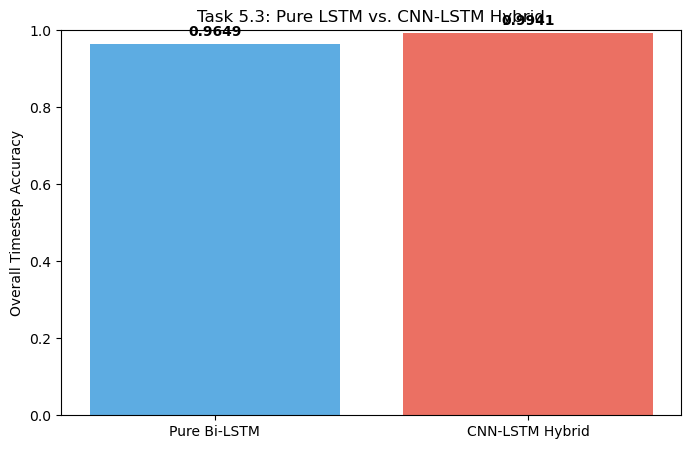

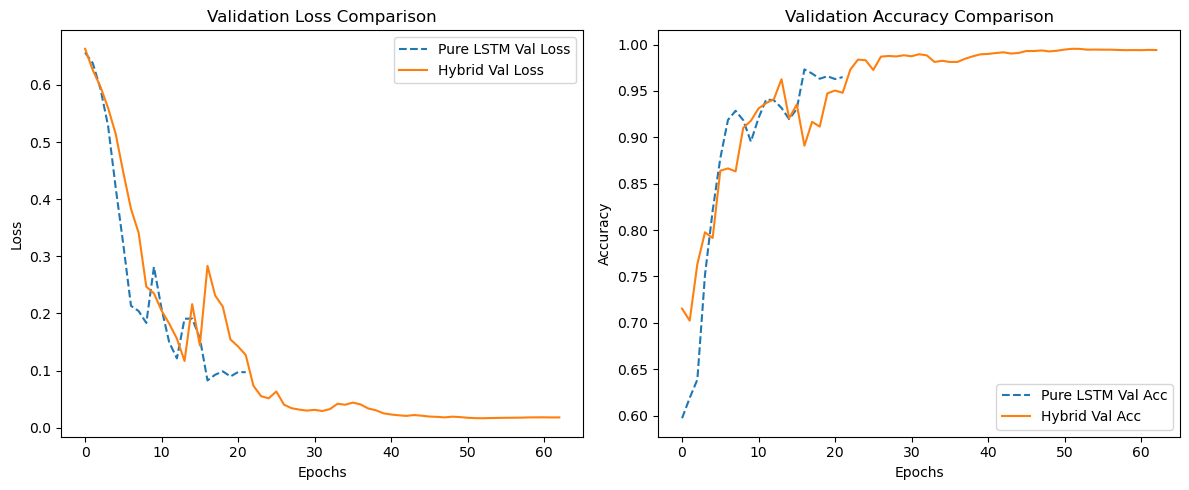

In [107]:
diff = acc_hybrid - acc_lstm
better_model = "CNN-LSTM" if diff > 0 else "Pure LSTM"

print(f"\n--- Performance Comparison ---")
print(f"Pure LSTM Accuracy:  {acc_lstm:.4f}")
print(f"CNN-LSTM Accuracy:   {acc_hybrid:.4f}")
print(f"Difference:          {abs(diff):.4f} in favor of {better_model}")

# --- Step 2: Visual Comparison of Accuracy ---
models = ['Pure Bi-LSTM', 'CNN-LSTM Hybrid']
accuracies = [acc_lstm, acc_hybrid]

plt.figure(figsize=(8, 5))
plt.bar(models, accuracies, color=['#3498db', '#e74c3c'], alpha=0.8)
plt.ylabel('Overall Timestep Accuracy')
plt.title('Task 5.3: Pure LSTM vs. CNN-LSTM Hybrid')
plt.ylim([0, 1.0]) # Accuracy is between 0 and 1
for i, v in enumerate(accuracies):
    plt.text(i, v + 0.02, f"{v:.4f}", ha='center', fontweight='bold')
plt.show()

# --- Step 3: Compare Training Curves ---
plt.figure(figsize=(12, 5))

# Plot Loss
plt.subplot(1, 2, 1)
plt.plot(history.history['val_loss'], label='Pure LSTM Val Loss', linestyle='--')
plt.plot(history_hybrid_v2.history['val_loss'], label='Hybrid Val Loss')
plt.title('Validation Loss Comparison')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

# Plot Accuracy
plt.subplot(1, 2, 2)
plt.plot(history.history['val_accuracy'], label='Pure LSTM Val Acc', linestyle='--')
plt.plot(history_hybrid_v2.history['val_accuracy'], label='Hybrid Val Acc')
plt.title('Validation Accuracy Comparison')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.tight_layout()
plt.show()

--- Comprehensive Model Comparison Table ---
Approach         Model  Accuracy                 Feature Type  Granularity
       A     SVM (RBF)  0.965568       Manual (Spectral/Temp)   Per Window
       A Random Forest  0.935402       Manual (Spectral/Temp)   Per Window
       A           KNN  0.963406       Manual (Spectral/Temp)   Per Window
       B       Bi-LSTM  0.964896         Automatic (Temporal) Per Timestep
       B      CNN-LSTM  0.994062 Automatic (Spatial-Temporal) Per Timestep


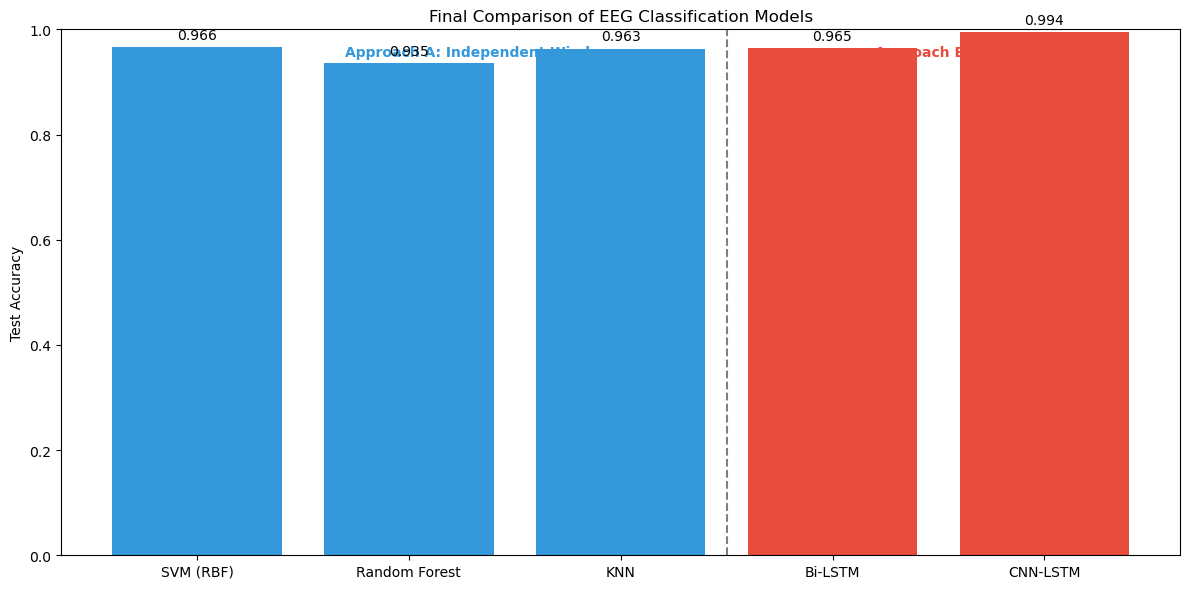

In [ ]:
#6
comparison_data = {
    'Approach': ['A', 'A', 'A', 'B', 'B'],
    'Model': ['SVM (RBF)', 'Random Forest', 'KNN', 'Bi-LSTM', 'CNN-LSTM'],
    'Accuracy': [
        results['SVM']['mean'],
        results['RF']['mean'],
        results['KNN']['mean'],
        acc_lstm,
        acc_hybrid
    ],
    'Feature Type': ['Manual (Spectral/Temp)', 'Manual (Spectral/Temp)', 'Manual (Spectral/Temp)',
                    'Automatic (Temporal)', 'Automatic (Spatial-Temporal)'],
    'Granularity': ['Per Window', 'Per Window', 'Per Window', 'Per Timestep', 'Per Timestep']
}

comparison_df = pd.DataFrame(comparison_data)

print("--- Comprehensive Model Comparison Table ---")
print(comparison_df.to_string(index=False))

plt.figure(figsize=(12, 6))
colors = ['#3498db', '#3498db', '#3498db', '#e74c3c', '#e74c3c']
bars = plt.bar(comparison_df['Model'], comparison_df['Accuracy'], color=colors)

plt.axvline(x=2.5, color='black', linestyle='--', alpha=0.5)
plt.text(0.7, 0.95, 'Approach A: Independent Windows', fontweight='bold', color='#3498db')
plt.text(3.2, 0.95, 'Approach B: Sequence Labeling', fontweight='bold', color='#e74c3c')

plt.ylabel('Test Accuracy')
plt.title('Final Comparison of EEG Classification Models')
plt.ylim(0, 1.0)

for bar in bars:
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2, yval + 0.01, f'{yval:.3f}', ha='center', va='bottom')

plt.tight_layout()
plt.show()